# Thomas the Steam Recommendation Engine - SteamGraph

## Building Graphs with Neural Nets to Find New Games to Play

by **Jarvin Bayona** **Moises Limon** **Andrew Hoang**


# Table of Contents
* [Preprocessing and Cleaning](#Preprocessing)
* [Graph Neural Network Architecture](#Modeling)
* [Visualize the Graph](#Visuals)
* [Visualize the Game Recommendation of each User](#Visualize-the-Game-Recommendation-of-each-User)



# Video Recording
* [Video Recording](https://drive.google.com/file/d/1x3uXhBMjOC_BZ-20t7j4aDMxL6Q79_Ph/view?usp=sharing)

# Medium Post
* [Medium Post](https://medium.com/@jarvinbiroselbayona/thomas-the-steam-recommendation-engine-building-graphs-with-neural-nets-to-find-new-games-to-play-9fa872b67de1)



# Preprocessing

### Steamspy

Get all the steam data in regards to its reviews and other stats. Game data only, no user data.

In [ ]:
import requests
import pandas as pd
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
import pandas as pd
import time

In [ ]:
# Create output directory if not exists
output_dir = "steamspy_pages"
os.makedirs(output_dir, exist_ok=True)

page = 0
pbar = tqdm(desc="Downloading SteamSpy Pages", unit="page")

while True:
    url = f"https://steamspy.com/api.php?request=all&page={page}"
    try:
        response = requests.get(url)
        data = response.json()

        if not data:
            print("No more data. Exiting loop.")
            break

        # Convert JSON dict to DataFrame
        df = pd.DataFrame.from_dict(data, orient='index')

        # Save to CSV
        filename = os.path.join(output_dir, f"steamspy_page_{page}.csv")
        df.to_csv(filename, index=False)

        # Update progress bar
        pbar.update(1)
        pbar.set_postfix_str(f"Page {page} saved")

        # Sleep to avoid hitting the request limit
        time.sleep(3)
        page += 1

    except Exception as e:
        print(f"Error on page {page}: {e}")
        break

pbar.close()


Fetch the reviews to find public steam ids 

In [ ]:
appid=2246340 # Example
num_pages=100

def fetch_reviews(appid, num_pages=10, delay=1):
    all_reviews = []
    cursor = '*'

    for page in range(num_pages):
        params = {
            'json': 1,
            'filter': 'recent',
            'language': 'english', 
            'purchase_type': 'all',
            'cursor': cursor
        }
        response = requests.get(f'https://store.steampowered.com/appreviews/{appid}', params=params)
        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")
            break

        data = response.json()
        reviews = data.get('reviews', [])
        if not reviews:
            print("No more reviews available.")
            break

        for review in reviews:
            author = review.get('author', {})
            review_data = {
                'steamid': author.get('steamid'),
                'num_games_owned': author.get('num_games_owned'),
                'num_reviews': author.get('num_reviews'),
                'playtime_forever': author.get('playtime_forever'),
                'playtime_last_two_weeks': author.get('playtime_last_two_weeks'),
                'review_text': review.get('review'),
                'timestamp_created': review.get('timestamp_created'),
                'voted_up': review.get('voted_up'),
                'votes_up': review.get('votes_up'),
                'votes_funny': review.get('votes_funny')
            }
            all_reviews.append(review_data)

        cursor = data.get('cursor', '')
        if not cursor:
            print("No further cursor found, ending pagination.")
            break

        print(f"Page {page + 1} fetched successfully.")
        time.sleep(delay)

    return all_reviews

# Fetch reviews for Marvel Rivals (AppID: 2767030)
reviews = fetch_reviews(appid, num_pages)

# Convert to DataFrame
df = pd.DataFrame(reviews)

# Display the first few rows
df.head()

# Optionally, save to CSV
df.to_csv(f"./reviews/{appid}.csv")

### Get user data

Get the user data from each of the pages of steam reviews.

In [ ]:
import pandas as pd
import glob
import os
import json

def consolidate_steamspy_data():
    # Path to your steamspy CSV files
    path = 'steamspy_pages/'
    

    all_files = glob.glob(os.path.join(path, "steamspy_page_*.csv"))
    
    df_list = []
    
    # Read each file into a dataframe and append to the list
    for filename in all_files:
        try:
            df = pd.read_csv(filename)
            df_list.append(df)
            print(f"Loaded {filename}: {len(df)} games")
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    # Concatenate all dataframes
    combined_df = pd.concat(df_list, axis=0, ignore_index=True)
    
    combined_df = combined_df.drop_duplicates(subset=['appid'])
    
    print(f"Total games after consolidation: {len(combined_df)}")
    
    numeric_columns = ['appid', 'positive', 'negative', 'userscore', 
                        'average_forever', 'average_2weeks', 
                        'median_forever', 'median_2weeks', 
                        'price', 'initialprice', 'discount', 'ccu']
    
    for col in numeric_columns:
        if col in combined_df.columns:
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
    
    if 'owners' in combined_df.columns:
        combined_df['owners_estimate'] = combined_df['owners'].str.split(' .. ').str[0].str.replace(',', '')
        combined_df['owners_estimate'] = pd.to_numeric(combined_df['owners_estimate'], errors='coerce')
    
    # Calculate review ratio
    combined_df['review_ratio'] = combined_df['positive'] / (combined_df['positive'] + combined_df['negative']).clip(lower=1)
    
    # Save to CSV
    combined_df.to_csv('consolidated_games.csv', index=False)
    
    return combined_df

games_df = consolidate_steamspy_data()

### Test the json of the interactions

In [ ]:
# Load collected user data
with open('./users/user_data_730.json', 'r') as f:
    user_data = json.load(f)

# Create interactions dataframe
interactions = []
for user in user_data:
    steam_id = user['steam_id']
    for game in user['response']['games']:
        interactions.append({
            'user_id': steam_id,
            'game_id': game['appid'],
            'playtime_forever': game['playtime_forever'],
            'playtime_2weeks': game.get('playtime_2weeks', 0)
        })

interactions_df = pd.DataFrame(interactions)

# Filter interactions to include only games in our games_df
valid_game_ids = set(games_df['appid'].values)
interactions_df = interactions_df[interactions_df['game_id'].isin(valid_game_ids)]

print(f"Total interactions: {len(interactions_df)}")
print(f"Unique users: {interactions_df['user_id'].nunique()}")
print(f"Unique games: {interactions_df['game_id'].nunique()}")

In [ ]:
df_tagged = pd.read_csv('steamspy_page_0_tags_final.csv')
for index in range(1,5):
    df_cur = pd.read_csv(f'steamspy_page_{index}_tags_final.csv')
    df_tagged = pd.concat([df_tagged, df_cur])
df_tagged.shape

In [ ]:
df_final = pd.merge(games_df, df_tagged, on='appid')
df_final = df_final.drop(columns = [ # MUST CHECK THIS EVERY UPDATE
    'score_rank', 'userscore', 'average_forever',
    'average_2weeks', 'median_forever', 'median_2weeks'
])
df_final = df_final[~df_final.isnull().any(axis=1)]
df_final.head()

### Use Beautiful Soup to process the html 

In [ ]:
from bs4 import BeautifulSoup

def clean_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

df_final["detailed_description"].apply(clean_html)

In [ ]:
print(clean_html(df_final['short_description'][0]))

### Lang Detect for english description and translation

In [ ]:
from langdetect import detect

df_final['detected_language'] = df_final['detailed_description'].apply(lambda x: detect(x))
len(df_final[df_final['detected_language'] != 'en']['detailed_description'].sum())

In [ ]:
categories = df_final['categories'].apply(eval)
categories = categories.explode()
categories.to_list()
categories = list(set(categories))
print(categories)

In [ ]:
# Drop the columns that we did in df_final

df_consolidated_users = pd.read_csv('consolidated_users_final.csv').add_prefix('user_')
df_consolidated_games = pd.read_csv('consolidated_games.csv').drop(columns = [ # MUST CHECK THIS EVERY UPDATE
    'score_rank', 'userscore', 'average_forever',
    'average_2weeks', 'median_forever', 'median_2weeks'
]).add_prefix('game_')

df_interactions = pd.merge(left =  df_consolidated_users, right = df_consolidated_games, left_on= 'user_appid', right_on = 'game_appid')
df_interactions.shape

In [ ]:
df_interactions.head()

In [ ]:
played_games = df_interactions['user_appid'].unique()
df_trimmed_games = list(set(df_consolidated_games['game_appid'].unique()).intersection(set(played_games)))
df_trimmed_games

In [ ]:
df_consolidated_tags = pd.read_csv('consolidated_tags.csv')
df_consolidated_tags.head()

In [ ]:
keep = ['appid', 'genres_en', 'categories_en', 'short_description_en', 'detailed_description_en']

df_trimmed_tags = df_consolidated_tags[keep]
df_trimmed_tags.head()

In [ ]:
df_final_fantasy = pd.merge(df_interactions, df_trimmed_tags, how = 'left', left_on = 'user_appid', right_on = 'appid')
df_final_fantasy.head()

In [ ]:
to_drop = ['user_appid', 'user_name', 'game_owners', 'game_positive', 'game_negative', 'appid']
df_final_fantasy = df_final_fantasy.drop(columns = to_drop)
df_final_fantasy['user_playtime_2weeks'] = df_final_fantasy['user_playtime_2weeks'].fillna(0)
df_final_fantasy['user_content_descriptorids'] = df_final_fantasy['user_content_descriptorids'].fillna('[0]')
df_final_fantasy['user_has_community_visible_stats'] = df_final_fantasy['user_has_community_visible_stats'].fillna(False)
df_final_fantasy['user_has_leaderboards'] = df_final_fantasy['user_has_leaderboards'].fillna(False)
df_final_fantasy['genres_en'] = df_final_fantasy['genres_en'].apply(lambda x: str(x).title())
df_final_fantasy['categories_en'] = df_final_fantasy['categories_en'].apply(lambda x: str(x).title())
df_final_fantasy['game_price'] = df_final_fantasy['game_price']/100
df_final_fantasy['game_initialprice'] = df_final_fantasy['game_initialprice']/100

In [ ]:
df_final_fantasy.to_csv('final_fantasy.csv')

# Modeling 

In [9]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear, ReLU
from torch.nn.functional import binary_cross_entropy
from torch.cuda.amp import GradScaler, autocast

import torch_geometric
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.nn import HeteroConv, SAGEConv, GCNConv
from sklearn.preprocessing import LabelEncoder

In [30]:
sample_ratio = 1 # We love global variables

# Memory optimization settings
torch.backends.cudnn.benchmark = True  # Optimize CuDNN
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8192"  # Limit CUDA allocation size

# Device configuration with fallback
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

cpu_device = torch.device('cpu')


Using device: cpu


### Memory Effificient GNN 

In [18]:
class GNN(nn.Module):
    def __init__(self, num_users, num_games, num_genres, embedding_dim=32):
        super().__init__()
        # Reduced embedding dimension
        self.embedding_dim = embedding_dim
        
        # Node embeddings
        self.user_embed = nn.Embedding(num_users, embedding_dim)
        self.game_embed = nn.Embedding(num_games, embedding_dim)
        self.genre_embed = nn.Embedding(num_genres, embedding_dim)
        
        # Edge projections (simpler than NNConv)
        self.edge_proj_plays = nn.Linear(1, embedding_dim//2)
        self.edge_proj_genre = nn.Linear(16, embedding_dim//2)  # Assuming reduced to 16D
        
        # Message passing layers
        self.conv1 = HeteroConv({
            ('user', 'plays', 'game'): SAGEConv((embedding_dim, embedding_dim), 
                                                embedding_dim),
            ('game', 'rev_plays', 'user'): SAGEConv((embedding_dim, embedding_dim), 
                                                   embedding_dim),
            ('game', 'has_genre', 'genre'): SAGEConv((embedding_dim, embedding_dim), 
                                                    embedding_dim),
            ('genre', 'rev_has_genre', 'game'): SAGEConv((embedding_dim, embedding_dim), 
                                                        embedding_dim),
        }, aggr='sum')
        
        # Layer normalization for stability
        self.layer_norms = nn.ModuleDict({
            'user': nn.LayerNorm(embedding_dim),
            'game': nn.LayerNorm(embedding_dim),
            'genre': nn.LayerNorm(embedding_dim)
        })
    
    def forward(self, x_dict, edge_index_dict):
        # Get initial embeddings
        x_dict = {
            'user': self.user_embed(x_dict['user']),
            'game': self.game_embed(x_dict['game']),
            'genre': self.genre_embed(x_dict['genre']),
        }
        
        # Apply convolutions (without edge attributes to save memory)
        x_dict = self.conv1(x_dict, edge_index_dict)
        
        # Apply layer normalization
        x_dict = {
            node_type: self.layer_norms[node_type](feat)
            for node_type, feat in x_dict.items()
        }
        
        return x_dict


### LinkPredictor

In [19]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        # Smaller, more efficient predictor
        self.net = nn.Sequential(
            nn.Linear(2 * embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Dropout(0.2),  # Regularization to prevent overfitting
            nn.Linear(embedding_dim, 1),
        )
    
    def forward(self, user_emb, game_emb):
        x = torch.cat([user_emb, game_emb], dim=-1)
        return torch.sigmoid(self.net(x)).squeeze()

In [20]:
def train_model_with_memory_optimization(h_data, model, predictor, num_epochs=50, batch_size=16, use_mixed_precision=True):
    """
    Train the model with memory optimizations
    """
    # Move data to device
    h_data = h_data.to(device)
    model = model.to(device)
    predictor = predictor.to(device)
    
    # Optimizer with weight decay for regularization
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(predictor.parameters()), 
        lr=0.001, 
        weight_decay=1e-5
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=5
        # verbose=True
    )
    
    # Initialize scaler for mixed precision training
    scaler = GradScaler() if use_mixed_precision else None
    
    # Get positive edges (user-plays-game)
    positive_edges = h_data['user', 'plays', 'game'].edge_index.t().tolist()
    
    # Negative edge sampling function
    def sample_batch(batch_size=128):
        # Sample positive edges
        pos_idx = random.sample(range(len(positive_edges)), min(batch_size, len(positive_edges)))
        pos_samples = [positive_edges[i] for i in pos_idx]
        
        # Sample negative edges (more efficiently)
        user_nodes = h_data['user'].x.tolist()
        game_nodes = h_data['game'].x.tolist()
        neg_samples = []
        
        while len(neg_samples) < batch_size:
            u = random.choice(user_nodes)
            g = random.choice(game_nodes)
            if [u, g] not in positive_edges and [u, g] not in neg_samples:
                neg_samples.append([u, g])
                
        return pos_samples, neg_samples[:batch_size]
    
    # Training loop
    progress_bar = tqdm(range(num_epochs), desc="Training")
    epoch_losses = []
    
    for epoch in progress_bar:
        model.train()
        predictor.train()
        
        epoch_loss = 0
        epoch_acc = 0
        num_batches = 0
        
        # Process multiple smaller batches per epoch
        for _ in range(max(1, 100 // batch_size)):  # Aim for ~100 samples per epoch
            # Sample a batch
            pos_edges, neg_edges = sample_batch(batch_size)
            edges = torch.tensor(pos_edges + neg_edges, dtype=torch.long).to(device)
            labels = torch.cat([
                torch.ones(len(pos_edges)),
                torch.zeros(len(neg_edges))
            ]).to(device)
            
            # Clear gradients
            optimizer.zero_grad()
            
            # Forward pass with memory optimizations
            if use_mixed_precision:
                with autocast():
                    # Get embeddings from model
                    x_dict = model(h_data.x_dict, h_data.edge_index_dict)
                    
                    # Extract user and game embeddings for the sampled edges
                    users, games = edges[:, 0], edges[:, 1]
                    user_emb = x_dict['user'][users]
                    game_emb = x_dict['game'][games]
                    
                    # Compute predictions
                    preds = predictor(user_emb, game_emb)
                    
                    # Compute loss
                    loss = F.binary_cross_entropy_with_logits(preds, labels)
                
                # Backward pass with scaling
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard forward pass (without mixed precision)
                x_dict = model(h_data.x_dict, h_data.edge_index_dict)
                users, games = edges[:, 0], edges[:, 1]
                user_emb = x_dict['user'][users]
                game_emb = x_dict['game'][games]
                preds = predictor(user_emb, game_emb)
                loss = F.binary_cross_entropy_with_logits(preds, labels)
                
                # Standard backward pass
                loss.backward()
                optimizer.step()
            
            # Compute accuracy
            with torch.no_grad():
                acc = (preds >= 0.5).float().eq(labels).float().mean().item()
            
            # Update stats
            epoch_loss += loss.item()
            epoch_acc += acc
            num_batches += 1
            
            # Free up GPU memory
            torch.cuda.empty_cache()
        
        # Compute epoch stats
        avg_loss = epoch_loss / num_batches
        avg_acc = epoch_acc / num_batches
        epoch_losses.append(avg_loss)
        
        # Update learning rate
        scheduler.step(avg_loss)
        
        # Update progress bar
        progress_bar.set_description(
            f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f}"
        )
    
    return model, predictor, epoch_losses


### Process the Steam Data

In [21]:
def process_steam_data(data_path, sample_ratio=0.2):
    """
    Process Steam dataset with memory considerations
    """
    # Load data with reduced size
    data = pd.read_csv(data_path)
    sample_size = int(len(data) * sample_ratio)
    data = data.sample(sample_size, random_state=42).reset_index(drop=True)
    
    # Extract needed columns to reduce memory
    smaller_df = data[['user_steam_id', 'game_appid', 'genres_en', 'user_playtime_forever']]
    
    # Encode categorical data
    user_encoder, game_encoder = LabelEncoder(), LabelEncoder()
    smaller_df['user_id'] = user_encoder.fit_transform(smaller_df['user_steam_id'])
    smaller_df['game_id'] = game_encoder.fit_transform(smaller_df['game_appid'])
    
    # Process genres
    genre_map = {}
    for genres in data['genres_en'].dropna():
        if genres == 'Nan':
            continue
        for genre in eval(genres):
            if genre not in genre_map:
                genre_map[genre] = len(genre_map)
    
    def genre_mapper(row):
        if row == 'Nan' or pd.isna(row):
            return []
        row = eval(row)
        return [genre_map[item] for item in row if item in genre_map]
    
    smaller_df['genre_ids'] = smaller_df['genres_en'].apply(genre_mapper)
    
    # Create heterogeneous graph data
    h_data = HeteroData()
    h_data['user'].x = torch.arange(len(user_encoder.classes_))
    h_data['game'].x = torch.arange(len(game_encoder.classes_))
    h_data['genre'].x = torch.arange(len(genre_map))
    
    # Normalize playtime
    playtime = torch.tensor(smaller_df['user_playtime_forever'].values, dtype=torch.float)
    playtime_norm = (playtime - playtime.min()) / (playtime.max() - playtime.min() + 1e-8)
    
    # Create edges
    user_game_edges = torch.tensor([
        smaller_df['user_id'].values,
        smaller_df['game_id'].values
    ], dtype=torch.long)
    h_data['user', 'plays', 'game'].edge_index = user_game_edges
    h_data['user', 'plays', 'game'].edge_attr = playtime_norm.unsqueeze(1)
    
    # Create game-genre edges
    game_genre_pairs = []
    for _, row in smaller_df.iterrows():
        for genre_id in row['genre_ids']:
            game_genre_pairs.append((row['game_id'], genre_id))
    
    if game_genre_pairs:
        game_genre_edges = torch.tensor(game_genre_pairs, dtype=torch.long).t()
        h_data['game', 'has_genre', 'genre'].edge_index = game_genre_edges
    
    # Make graph undirected
    h_data = ToUndirected()(h_data)
    
    return h_data, user_encoder, game_encoder, genre_map


In [22]:
def get_game_recommendations(model, predictor, h_data, user_id, top_k=10):
    """Get game recommendations for a specific user"""
    model.eval()
    predictor.eval()
    
    with torch.no_grad():
        # Get all node embeddings
        x_dict = model(h_data.x_dict, h_data.edge_index_dict)
        
        # Get user embedding
        user_emb = x_dict['user'][user_id].unsqueeze(0)
        
        # Get all game embeddings
        game_embs = x_dict['game']
        
        # For each game, compute prediction score
        scores = []
        batch_size = 128  # Process in batches to avoid OOM
        
        for i in range(0, len(game_embs), batch_size):
            batch_embs = game_embs[i:i+batch_size]
            batch_user_embs = user_emb.repeat(len(batch_embs), 1)
            batch_scores = predictor(batch_user_embs, batch_embs)
            scores.append(batch_scores)
        
        scores = torch.cat(scores)
        
        # Get indices of top-k games
        _, top_indices = torch.topk(scores, k=top_k)
        
        return top_indices.cpu().numpy()



In [23]:
def get_similar_games_by_genre(model, h_data, game_id, top_k=10):
    """Find games similar to a given game based on genre embeddings"""
    model.eval()
    
    with torch.no_grad():
        # Get all node embeddings
        x_dict = model(h_data.x_dict, h_data.edge_index_dict)
        
        # Get game embedding
        game_emb = x_dict['game'][game_id].unsqueeze(0)
        
        # Get all game embeddings
        all_game_embs = x_dict['game']
        
        # Compute cosine similarity between target game and all other games
        cosine_sim = F.cosine_similarity(game_emb, all_game_embs)
        
        # Set similarity to target game to -1 (to exclude it from results)
        cosine_sim[game_id] = -1
        
        # Get indices of top-k similar games
        _, top_indices = torch.topk(cosine_sim, k=top_k)
        
        return top_indices.cpu().numpy()



In [24]:
def proccessing_model():
    # Process data with memory considerations
    h_data, user_encoder, game_encoder, genre_map = process_steam_data(
        'final_fantasy.csv', 
        sample_ratio= sample_ratio
    )
    
    # Create model with smaller dimensions
    model = GNN(
        num_users=h_data['user'].num_nodes,
        num_games=h_data['game'].num_nodes,
        num_genres=h_data['genre'].num_nodes,
        embedding_dim=32  # Smaller embedding dimension
    )
    
    # Create predictor
    predictor = LinkPredictor(embedding_dim=32)
    
    # Train model
    model, predictor, losses = train_model_with_memory_optimization(
        h_data,
        model,
        predictor,
        num_epochs=50,
        batch_size=16,
        use_mixed_precision=True
    )
    
    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'predictor_state_dict': predictor.state_dict(),
        'losses': losses
    }, 'game_recommendation_model.pt')
    
    print("Training complete. Model saved.")

# Processing model with all Interactions

In [25]:
proccessing_model()

/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df['user_id'] = user_encoder.fit_transform(smaller_df['user_steam_id'])
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df['game_id'] = game_encoder.fit_transform(smaller_df['game_appid'])
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:33: SettingWithCop

Training complete. Model saved.


# Visualize the SteamGraph using NetworkX

In [26]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


In [33]:
def create_game_mapper(data_path='final_fantasy.csv'):
    """
    Create a mapper from game IDs to game names.
    Only loads the CSV once for efficiency.
    """
    # Convert the two columns into a dictionary
    df = pd.read_csv(data_path)
    game_mapper = dict(zip(df['game_appid'], df['game_name']))
    return game_mapper


def load_model_and_data(model_path='game_recommendation_model_100.pt', data_path='final_fantasy.csv', sample_ratio = .20):
    """Load the trained model and data"""
    # Process data to get the correct dimensions
    h_data, user_encoder, game_encoder, genre_map = process_steam_data(
        data_path, 
        sample_ratio= sample_ratio
    )
    
    # Get dimensions from the data
    num_users = h_data['user'].num_nodes
    num_games = h_data['game'].num_nodes
    num_genres = h_data['genre'].num_nodes
    
    print(f"Network dimensions: {num_users} users, {num_games} games, {num_genres} genres")
    
    # Create game mapper once
    game_mapper = create_game_mapper(data_path)
    
    # Load saved model
    checkpoint = torch.load(model_path, map_location=cpu_device)
    
    # Initialize models with correct dimensions
    model = GNN(
        num_users=num_users,
        num_games=num_games,
        num_genres=num_genres,
        embedding_dim=32
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    
    predictor = LinkPredictor(embedding_dim=32)
    predictor.load_state_dict(checkpoint['predictor_state_dict'])
    
    # Move to correct device
    model = model.to(device)
    predictor = predictor.to(device)
    h_data = h_data.to(device)
    
    return model, predictor, h_data, user_encoder, game_encoder, genre_map, game_mapper




# Visuals

In [46]:
def visualize_game_recommendation_network(h_data, user_encoder, game_encoder, genre_map, game_mapper, sample_users=3, sample_games=10, sample_genres=5):
    """
    Create a network visualization of the game recommendation system using NetworkX
    """
    print("Generating network graph visualization...")
    
    # Create a new graph
    G = nx.Graph()
    
    # Get edge indices
    user_game_edges = h_data['user', 'plays', 'game'].edge_index.cpu().numpy()
    game_genre_edges = h_data['game', 'has_genre', 'genre'].edge_index.cpu().numpy() if ('game', 'has_genre', 'genre') in h_data.edge_index_dict else None
    
    # Sample users, games, and genres
    all_users = np.unique(user_game_edges[0])
    sampled_users = np.random.choice(all_users, min(sample_users, len(all_users)), replace=False)
    
    # Find games connected to sampled users
    user_connected_games = set()
    for user_id in sampled_users:
        games = user_game_edges[1, user_game_edges[0] == user_id]
        user_connected_games.update(games)
    
    # If we have too many connected games, sample from them
    if len(user_connected_games) > sample_games:
        sampled_games = np.random.choice(list(user_connected_games), sample_games, replace=False)
    else:
        sampled_games = np.array(list(user_connected_games))
    
    # Find genres connected to sampled games
    game_connected_genres = set()
    if game_genre_edges is not None:
        for game_id in sampled_games:
            genres = game_genre_edges[1, game_genre_edges[0] == game_id]
            game_connected_genres.update(genres)
        
        # If we have too many connected genres, sample from them
        if len(game_connected_genres) > sample_genres:
            sampled_genres = np.random.choice(list(game_connected_genres), sample_genres, replace=False)
        else:
            sampled_genres = np.array(list(game_connected_genres))
    else:
        sampled_genres = []
    
    # Reverse the genre map to get names
    reverse_genre_map = {v: k for k, v in genre_map.items()}
    
    # Add nodes to the graph with proper labels
    # Add user nodes
    for user_id in sampled_users:
        original_id = user_encoder.inverse_transform([user_id])[0]
        G.add_node(f"user_{user_id}", label=f"User {original_id}", type='user')
    
    # Add game nodes
    for game_id in sampled_games:
        original_id = game_encoder.inverse_transform([game_id])[0]
        game_name = game_mapper.get(original_id, f"Game {original_id}")
        G.add_node(f"game_{game_id}", label=f"{game_name}", type='game')
    
    # Add genre nodes
    for genre_id in sampled_genres:
        genre_name = reverse_genre_map.get(genre_id, f"Genre {genre_id}")
        G.add_node(f"genre_{genre_id}", label=genre_name, type='genre')
    
    # Add edges
    # Add user-game edges
    for user_id in sampled_users:
        for game_id in user_game_edges[1, user_game_edges[0] == user_id]:
            if game_id in sampled_games:
                # Find the edge attribute (playtime)
                edge_idx = np.where((user_game_edges[0] == user_id) & (user_game_edges[1] == game_id))[0]
                if len(edge_idx) > 0:
                    edge_idx = edge_idx[0]
                    # Get playtime if available
                    if hasattr(h_data['user', 'plays', 'game'], 'edge_attr'):
                        playtime = h_data['user', 'plays', 'game'].edge_attr[edge_idx].item()
                        G.add_edge(f"user_{user_id}", f"game_{game_id}", weight=playtime, type='plays')
                    else:
                        G.add_edge(f"user_{user_id}", f"game_{game_id}", type='plays')
    
    # Add game-genre edges
    if game_genre_edges is not None:
        for game_id in sampled_games:
            for genre_id in game_genre_edges[1, game_genre_edges[0] == game_id]:
                if genre_id in sampled_genres:
                    G.add_edge(f"game_{game_id}", f"genre_{genre_id}", type='has_genre')
    
    # Set up the plot
    plt.figure(figsize=(14, 10))
    
    # Define node positions using spring layout
    pos = nx.spring_layout(G, seed=42, k=0.8)
    
    # Define node colors and sizes by type
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        if G.nodes[node]['type'] == 'user':
            node_colors.append('royalblue')
            node_sizes.append(800)
        elif G.nodes[node]['type'] == 'game':
            node_colors.append('tomato')
            node_sizes.append(600)
        else:  # genre
            node_colors.append('limegreen')
            node_sizes.append(400)
    
    # Define edge colors and widths by type
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        if data['type'] == 'plays':
            edge_colors.append('darkblue')
            # Use weight (playtime) for edge width if available
            if 'weight' in data:
                edge_widths.append(1 + 3 * data['weight'])  # Scale playtime to a visible width
            else:
                edge_widths.append(1.5)
        else:  # has_genre
            edge_colors.append('darkgreen')
            edge_widths.append(1.0)
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6)
    
    # Draw labels with custom positioning
    label_pos = {k: (v[0], v[1] + 0.05) for k, v in pos.items()}  # Adjust label positions
    nx.draw_networkx_labels(G, label_pos, labels={n: G.nodes[n]['label'] for n in G.nodes()}, 
                          font_size=10, font_weight='bold')
    
    plt.title('Game Recommendation Network', fontsize=16)
    plt.axis('off')  # Turn off the axis
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue', markersize=10, label='Users'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=10, label='Games'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='limegreen', markersize=10, label='Genres'),
        Line2D([0], [0], color='darkblue', lw=2, label='User plays Game'),
        Line2D([0], [0], color='darkgreen', lw=2, label='Game has Genre')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('game_recommendation_network.png', dpi=300)
    plt.show()


def visualize_high_degree_network(h_data, user_encoder, game_encoder, genre_map, game_mapper, top_k=5):
    """
    Create a network visualization focusing on high-degree nodes (popular games/users)
    """
    print("Generating high-degree network visualization...")
    
    # Create a new graph
    G = nx.Graph()
    
    # Get edge indices
    user_game_edges = h_data['user', 'plays', 'game'].edge_index.cpu().numpy()
    game_genre_edges = h_data['game', 'has_genre', 'genre'].edge_index.cpu().numpy() if ('game', 'has_genre', 'genre') in h_data.edge_index_dict else None
    
    # Calculate node degrees
    user_degrees = {}
    for user_id in np.unique(user_game_edges[0]):
        user_degrees[user_id] = np.sum(user_game_edges[0] == user_id)
    
    game_degrees = {}
    for game_id in np.unique(user_game_edges[1]):
        game_degrees[game_id] = np.sum(user_game_edges[1] == game_id)
    
    genre_degrees = {}
    if game_genre_edges is not None:
        for genre_id in np.unique(game_genre_edges[1]):
            genre_degrees[genre_id] = np.sum(game_genre_edges[1] == genre_id)
    
    # Get top-k nodes by degree
    top_users = sorted(user_degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]
    top_users = [user_id for user_id, _ in top_users]
    
    top_games = sorted(game_degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]
    top_games = [game_id for game_id, _ in top_games]
    
    if game_genre_edges is not None:
        top_genres = sorted(genre_degrees.items(), key=lambda x: x[1], reverse=True)[:top_k]
        top_genres = [genre_id for genre_id, _ in top_genres]
    else:
        top_genres = []
    
    # Reverse the genre map to get names
    reverse_genre_map = {v: k for k, v in genre_map.items()}
    
    # Add nodes to the graph with proper labels
    # Add user nodes
    for user_id in top_users:
        original_id = user_encoder.inverse_transform([user_id])[0]
        degree = user_degrees[user_id]
        G.add_node(f"user_{user_id}", label=f"User {original_id}\n({degree} games)", type='user', degree=degree)
    
    # Add game nodes
    for game_id in top_games:
        original_id = game_encoder.inverse_transform([game_id])[0]
        degree = game_degrees[game_id]
        game_name = game_mapper.get(original_id, f"Game {original_id}")
        G.add_node(f"game_{game_id}", label=f"{game_name}\n({degree} users)", type='game', degree=degree)
    
    # Add genre nodes
    for genre_id in top_genres:
        genre_name = reverse_genre_map.get(genre_id, f"Genre {genre_id}")
        degree = genre_degrees[genre_id]
        G.add_node(f"genre_{genre_id}", label=f"{genre_name}\n({degree} games)", type='genre', degree=degree)
    
    # Add edges
    # Add user-game edges
    for user_id in top_users:
        for game_id in user_game_edges[1, user_game_edges[0] == user_id]:
            if game_id in top_games:
                # Find the edge attribute (playtime)
                edge_idx = np.where((user_game_edges[0] == user_id) & (user_game_edges[1] == game_id))[0]
                if len(edge_idx) > 0:
                    edge_idx = edge_idx[0]
                    # Get playtime if available
                    if hasattr(h_data['user', 'plays', 'game'], 'edge_attr'):
                        playtime = h_data['user', 'plays', 'game'].edge_attr[edge_idx].item()
                        G.add_edge(f"user_{user_id}", f"game_{game_id}", weight=playtime, type='plays')
                    else:
                        G.add_edge(f"user_{user_id}", f"game_{game_id}", type='plays')
    
    # Add game-genre edges
    if game_genre_edges is not None:
        for game_id in top_games:
            for genre_id in game_genre_edges[1, game_genre_edges[0] == game_id]:
                if genre_id in top_genres:
                    G.add_edge(f"game_{game_id}", f"genre_{genre_id}", type='has_genre')
    
    # Set up the plot
    plt.figure(figsize=(16, 12))
    
    # Define node positions using spring layout with increased k value
    # Increasing k makes nodes more spread out
    pos = nx.spring_layout(G, seed=42, k=1.0)  # Switched from kamada_kawai to spring layout with higher k
    
    # Define node colors and sizes by type and degree
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        degree = G.nodes[node]['degree']
        if G.nodes[node]['type'] == 'user':
            node_colors.append('royalblue')
            node_sizes.append(300 + 5 * degree)  # Reduced size multiplier
        elif G.nodes[node]['type'] == 'game':
            node_colors.append('tomato')
            node_sizes.append(400 + 5 * degree)  # Reduced size multiplier
        else:  # genre
            node_colors.append('limegreen')
            node_sizes.append(.10 * degree)  # Much smaller size multiplier for genres
    
    # Define edge colors and widths by type
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        if data['type'] == 'plays':
            edge_colors.append('darkblue')
            # Use weight (playtime) for edge width if available
            if 'weight' in data:
                edge_widths.append(0.5 + 1 * data['weight'])  # Reduced scale factor
            else:
                edge_widths.append(1.0)
        else:  # has_genre
            edge_colors.append('darkgreen')
            edge_widths.append(0.8)  # Thinner lines
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6)
    
    # Create a smaller font size for labels
    font_sizes = {}
    for node in G.nodes():
        if G.nodes[node]['type'] == 'genre':
            font_sizes[node] = 7  # Smaller font for genres
        else:
            font_sizes[node] = 9  # Regular font for other nodes
    
    # Draw labels with custom positioning and font sizes
    for node, (x, y) in pos.items():
        plt.text(x, y + 0.02, G.nodes[node]['label'], 
                fontsize=font_sizes[node], ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
    
    plt.title('High-Degree Nodes in Game Recommendation Network', fontsize=16)
    plt.axis('off')  # Turn off the axis
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue', markersize=10, label='Users'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=10, label='Games'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='limegreen', markersize=10, label='Genres'),
        Line2D([0], [0], color='darkblue', lw=2, label='User plays Game'),
        Line2D([0], [0], color='darkgreen', lw=2, label='Game has Genre')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('high_degree_network.png', dpi=300)
    plt.show()


    
def visualize_embeddings_network(model, h_data, user_encoder, game_encoder, game_mapper, n_nodes=20, threshold=0.6):
    """
    Create a network visualization based on embedding similarities
    """
    print("Generating embedding-based network visualization...")
    
    model.eval()
    with torch.no_grad():
        # Get embeddings
        x_dict = model(h_data.x_dict, h_data.edge_index_dict)
        
        # Sample random nodes
        user_ids = torch.randint(0, h_data['user'].num_nodes, (n_nodes//2,))
        game_ids = torch.randint(0, h_data['game'].num_nodes, (n_nodes//2,))
        
        # Get embeddings for sampled nodes
        user_embs = x_dict['user'][user_ids].cpu()
        game_embs = x_dict['game'][game_ids].cpu()
        
        # Create a new graph
        G = nx.Graph()
        
        # Add user nodes
        for i, user_id in enumerate(user_ids.cpu().numpy()):
            original_id = user_encoder.inverse_transform([user_id])[0]
            G.add_node(f"user_{user_id}", label=f"User {original_id}", type='user', 
                      emb=user_embs[i].numpy())
        
        # Add game nodes - using the passed game_mapper
        for i, game_id in enumerate(game_ids.cpu().numpy()):
            original_id = game_encoder.inverse_transform([game_id])[0]
            game_name = game_mapper.get(original_id, f"Game {original_id}")
            G.add_node(f"game_{game_id}", label=game_name, type='game',
                      emb=game_embs[i].numpy())
        
        # Add edges based on embedding similarity
        node_list = list(G.nodes())
        for i in range(len(node_list)):
            for j in range(i+1, len(node_list)):
                node_i = node_list[i]
                node_j = node_list[j]
                emb_i = G.nodes[node_i]['emb']
                emb_j = G.nodes[node_j]['emb']
                
                # Calculate cosine similarity
                cos_sim = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))
                
                # Add edge if similarity exceeds threshold
                if cos_sim > threshold:
                    G.add_edge(node_i, node_j, weight=cos_sim, similarity=cos_sim)
        
        # Set up the plot
        plt.figure(figsize=(12, 10))
        
        # Use a force-directed layout
        pos = nx.spring_layout(G, seed=42, k=0.5)
        
        # Node colors based on type
        node_colors = ['royalblue' if G.nodes[n]['type'] == 'user' else 'tomato' for n in G.nodes()]
        
        # Edge width based on similarity
        edge_weights = [G[u][v]['weight'] * 3 for u, v in G.edges()]
        
        # Draw the network
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color='gray')
        nx.draw_networkx_labels(G, pos, labels={n: G.nodes[n]['label'] for n in G.nodes()}, 
                              font_size=8, font_weight='bold')
        
        plt.title('Embedding Similarity Network', fontsize=16)
        plt.axis('off')
        
        # Add a legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue', markersize=10, label='Users'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=10, label='Games'),
            Line2D([0], [0], color='gray', lw=2, label='Similarity > {:.1f}'.format(threshold))
        ]
        plt.legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.savefig('embedding_network.png', dpi=300)
        plt.show()


/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df['user_id'] = user_encoder.fit_transform(smaller_df['user_steam_id'])
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df['game_id'] = game_encoder.fit_transform(smaller_df['game_appid'])
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:33: SettingWithCop

Network dimensions: 5842 users, 31397 games, 41 genres
Generating network graph visualization...


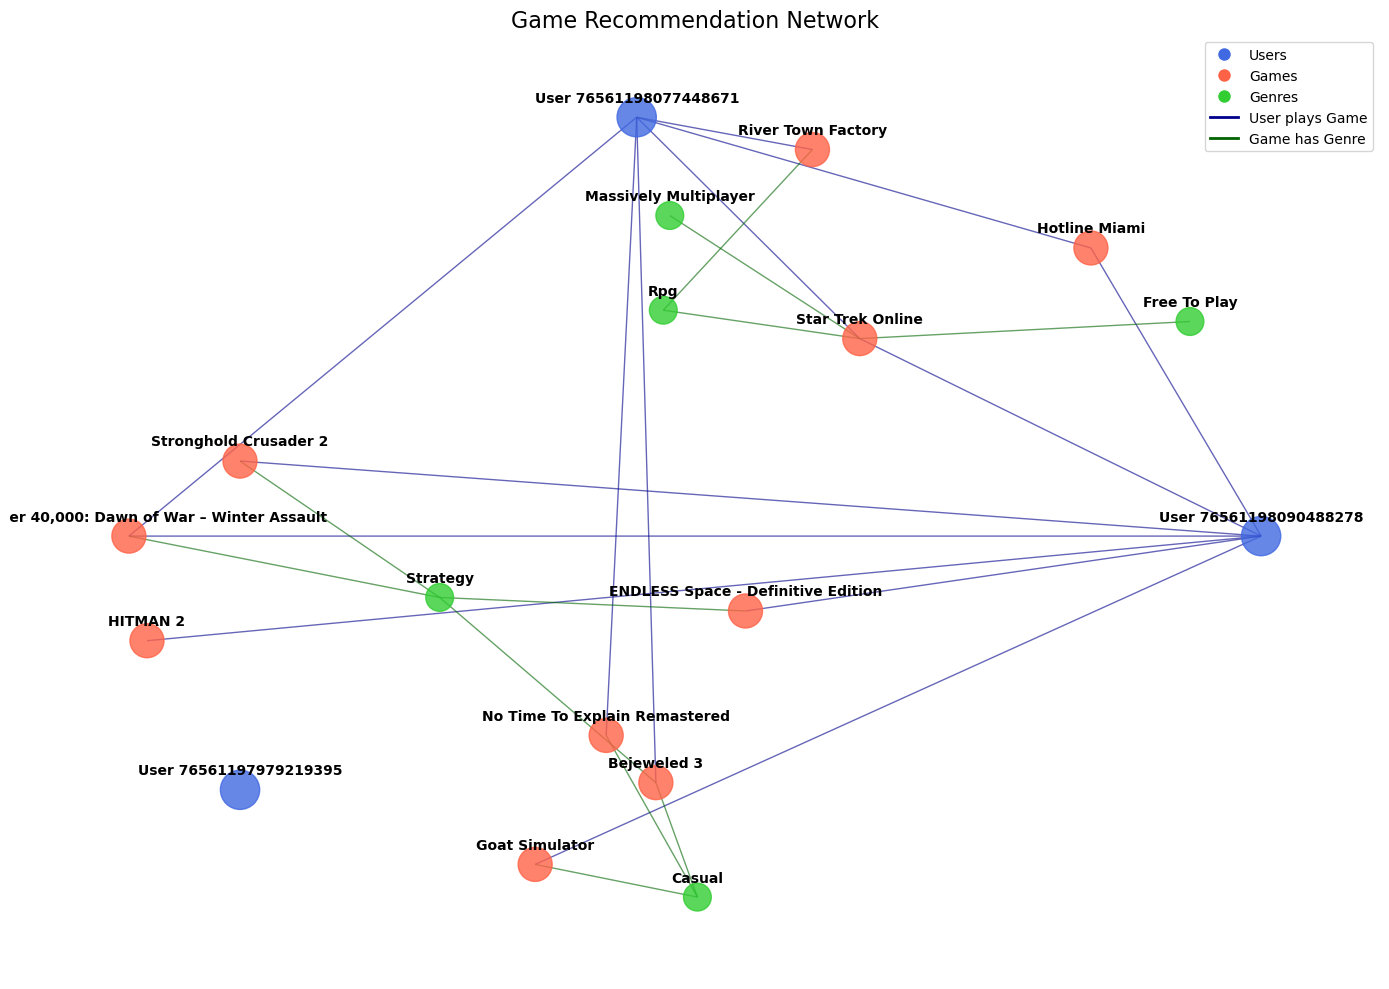

Generating high-degree network visualization...


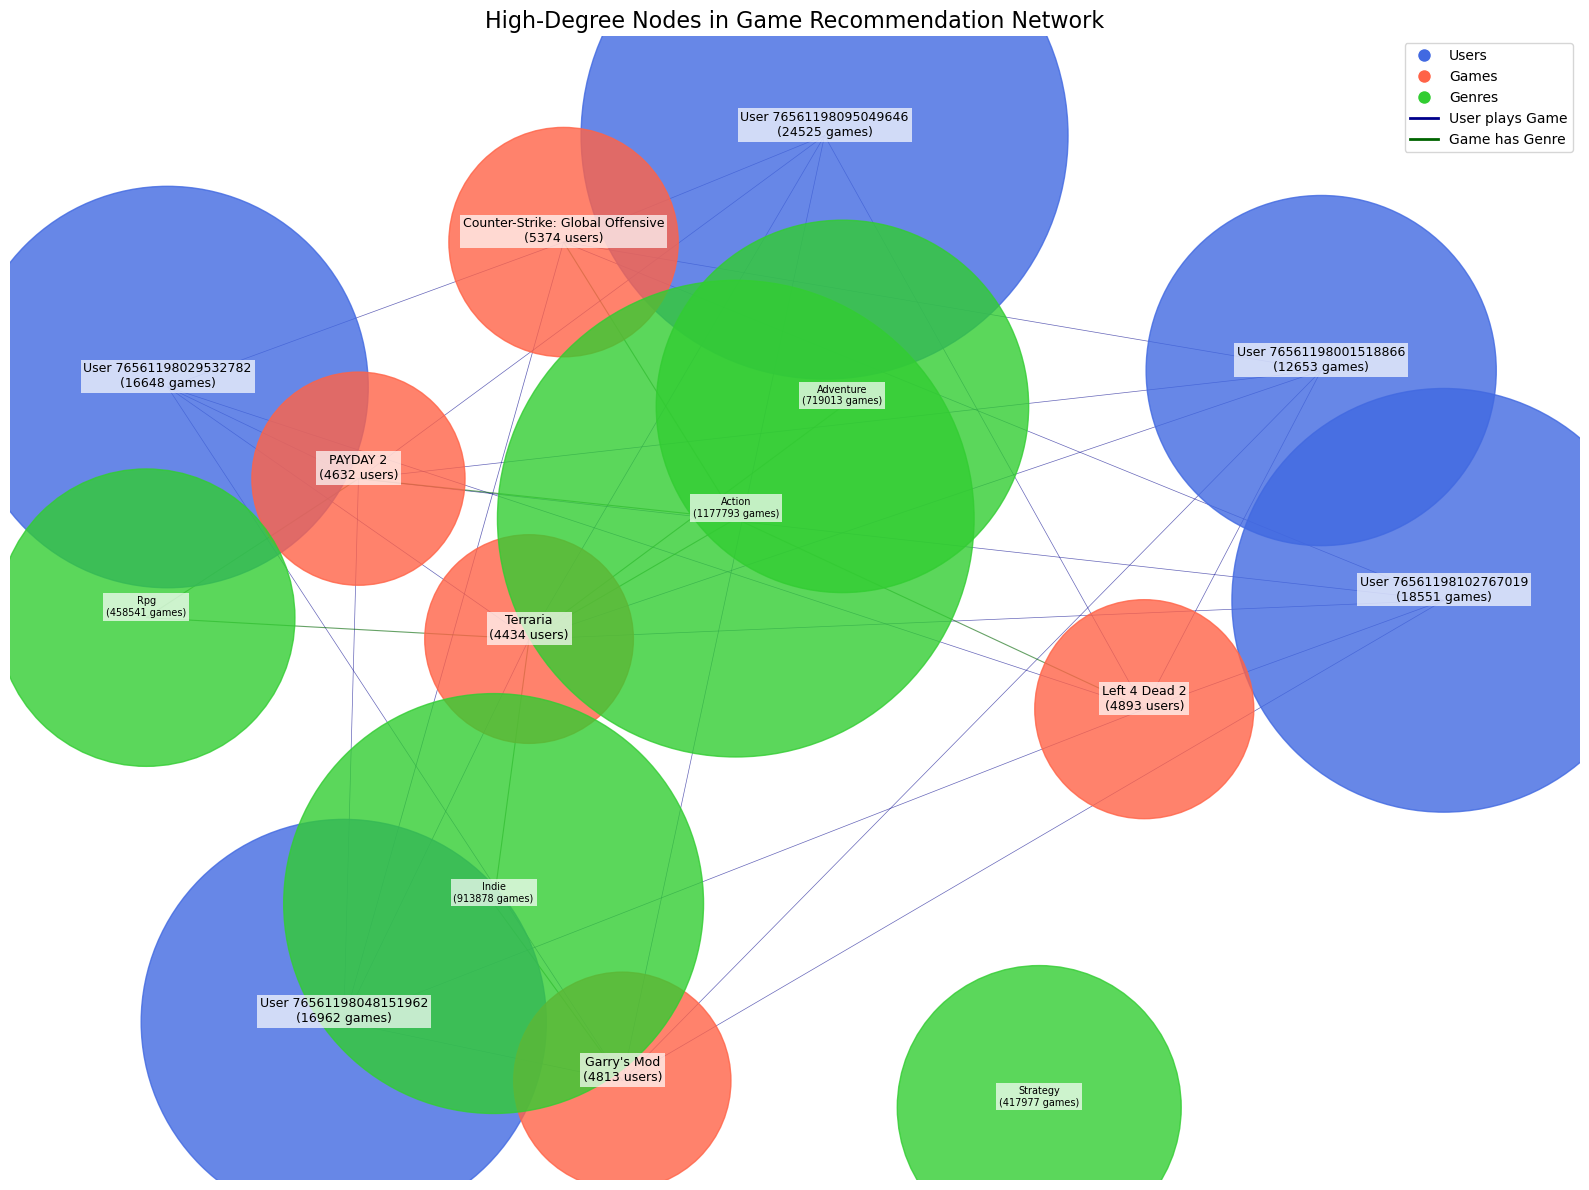

Generating embedding-based network visualization...


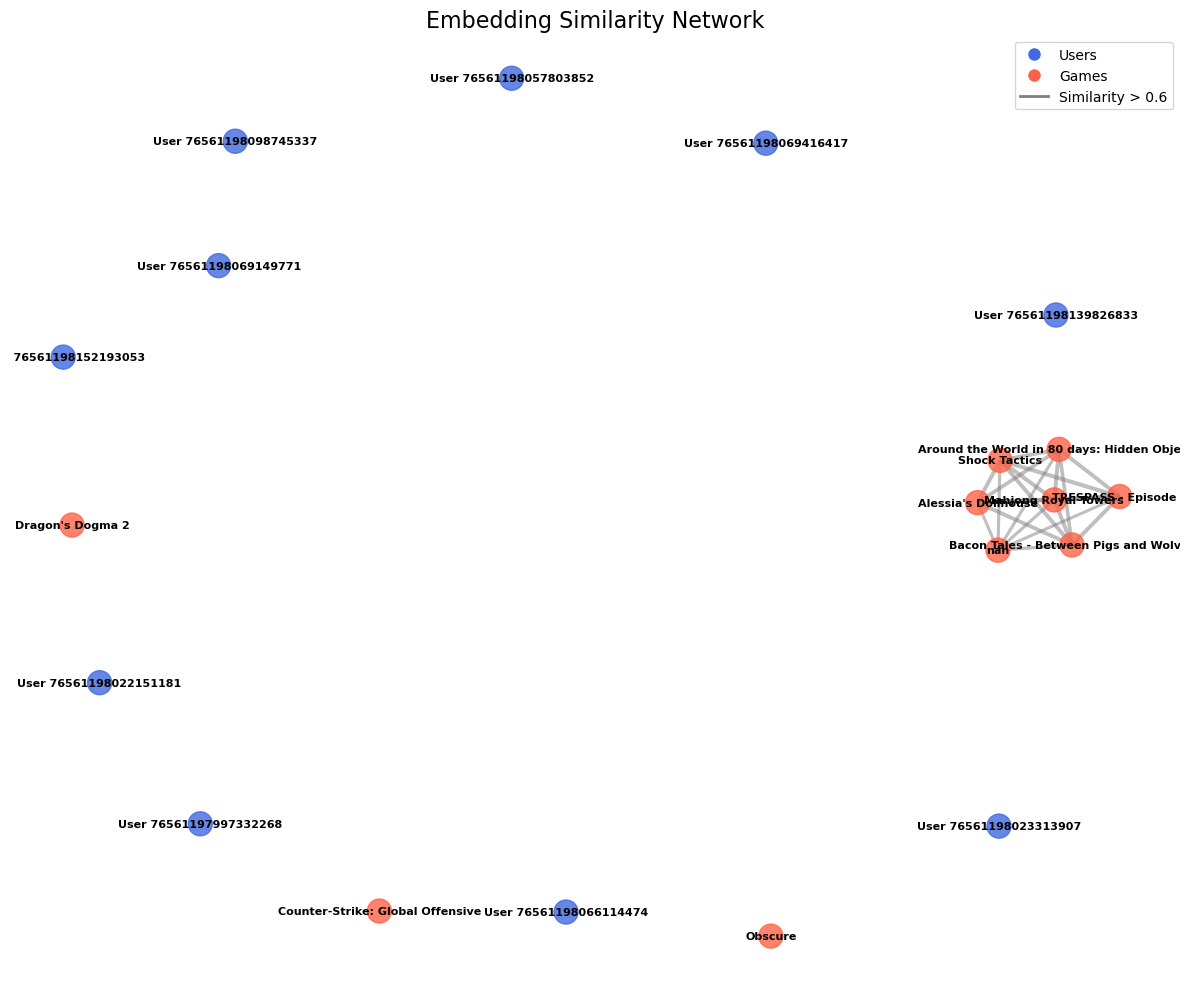

Network visualizations completed and saved!


In [47]:
model, predictor, h_data, user_encoder, game_encoder, genre_map, game_mapper = load_model_and_data(sample_ratio = sample_ratio)

# Generate network visualizations
visualize_game_recommendation_network(h_data, user_encoder, game_encoder, genre_map, game_mapper)
visualize_high_degree_network(h_data, user_encoder, game_encoder, genre_map, game_mapper)
visualize_embeddings_network(model, h_data, user_encoder, game_encoder, game_mapper)

print("Network visualizations completed and saved!")

# Visualize the Game Recommendation of each User

/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df['user_id'] = user_encoder.fit_transform(smaller_df['user_steam_id'])
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smaller_df['game_id'] = game_encoder.fit_transform(smaller_df['game_appid'])
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/1823201430.py:33: SettingWithCop

Network dimensions: 5842 users, 31397 games, 41 genres
Generating game recommendations visualization for User 76561198059680033...


/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/2140258535.py:112: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6,
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/2140258535.py:145: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/2140258535.py:145: UserWarning: Glyph 51396 (\N{HANGUL SYLLABLE JOE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/n_/3_x326jx1px01h5tp8dtcgzw0000gn/T/ipykernel_49529/2140258535.py:145: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) De

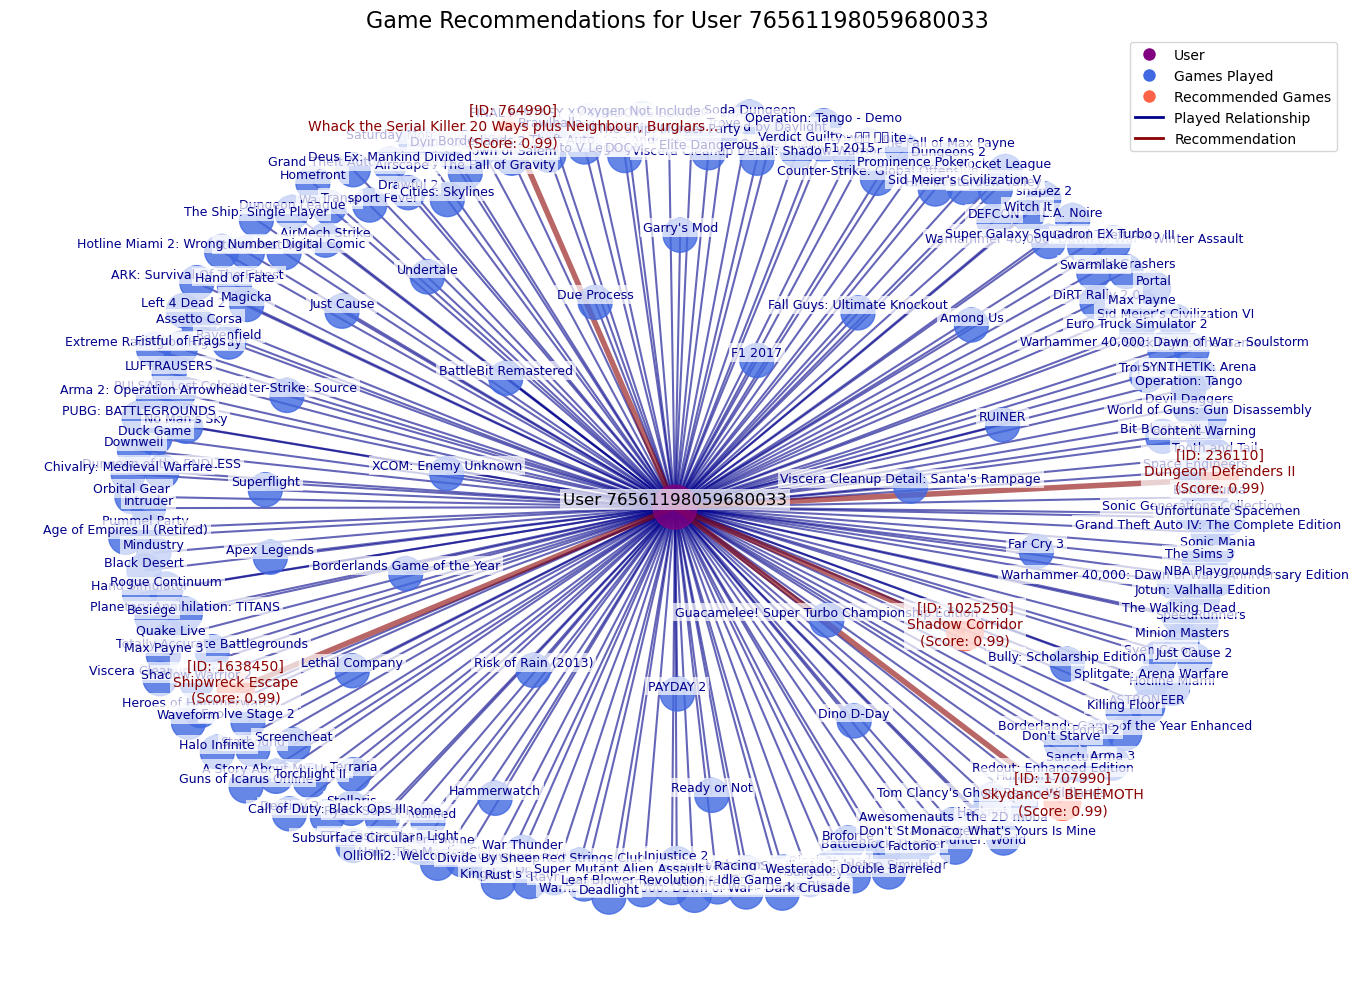

Visualizations completed and saved!


In [45]:
def visualize_game_recommendations(model, predictor, h_data, user_encoder, game_encoder, game_mapper, user_steam_id, top_k=5):
    """
    Visualize game recommendations for a specific user
    
    Args:
        model: Trained GNN model
        predictor: Trained link predictor
        h_data: Heterogeneous graph data
        user_encoder: LabelEncoder for users
        game_encoder: LabelEncoder for games
        game_mapper: Dictionary mapping game IDs to game names
        user_steam_id: Original user Steam ID to visualize recommendations for
        top_k: Number of recommendations to show
    """
    print(f"Generating game recommendations visualization for User {user_steam_id}...")
    
    # Convert user_steam_id to internal user_id
    try:
        # Find the encoded user ID
        user_id = np.where(user_encoder.classes_ == user_steam_id)[0][0]
    except (IndexError, TypeError):
        print(f"User {user_steam_id} not found in the dataset")
        return
    
    # Get recommendations
    model.eval()
    predictor.eval()
    
    # Move to appropriate device
    model = model.to(device)
    predictor = predictor.to(device)
    h_data = h_data.to(device)
    
    # Get game recommendations
    recommended_game_ids = get_game_recommendations(model, predictor, h_data, user_id, top_k=top_k)
    
    # Create a new graph
    G = nx.Graph()
    
    # Add user node
    G.add_node(f"user_{user_id}", label=f"User {user_steam_id}", type='user')
    
    # Get user-game edges (games the user has already played)
    user_game_edges = h_data['user', 'plays', 'game'].edge_index.cpu().numpy()
    user_games = user_game_edges[1, user_game_edges[0] == user_id]
    
    # Add nodes for existing games (what user has played)
    existing_games = []
    for game_id in user_games:
        game_id = game_id.item()  # Convert tensor to int
        original_id = game_encoder.inverse_transform([game_id])[0]
        game_name = game_mapper.get(original_id, f"Game {original_id}")
        G.add_node(f"played_{game_id}", label=game_name, type='played')
        G.add_edge(f"user_{user_id}", f"played_{game_id}", type='played')
        existing_games.append(game_id)
    
    # Add nodes for recommended games
    for i, game_id in enumerate(recommended_game_ids):
        # Get the original game ID
        original_id = game_encoder.inverse_transform([game_id])[0]
        game_name = game_mapper.get(original_id, f"Game {original_id}")
        
        # Get recommendation score
        with torch.no_grad():
            # Get embeddings
            x_dict = model(h_data.x_dict, h_data.edge_index_dict)
            user_emb = x_dict['user'][user_id].unsqueeze(0)
            game_emb = x_dict['game'][game_id].unsqueeze(0)
            score = predictor(user_emb, game_emb).item()
        
        # Add node and edge
        G.add_node(f"rec_{game_id}", label=f"[ID: {original_id}]\n{game_name}\n(Score: {score:.2f})", type='recommended')
        G.add_edge(f"user_{user_id}", f"rec_{game_id}", type='recommended', weight=score)
    
    # Set up the plot
    plt.figure(figsize=(14, 10))
    
    # Define node positions using a radial layout
    pos = nx.spring_layout(G, seed=42, k=0.8)
    
    # Define node colors and sizes by type
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        if G.nodes[node]['type'] == 'user':
            node_colors.append('purple')
            node_sizes.append(1000)
        elif G.nodes[node]['type'] == 'played':
            node_colors.append('royalblue')
            node_sizes.append(600)
        else:  # recommended
            node_colors.append('tomato')
            node_sizes.append(700)
    
    # Define edge colors and widths by type
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        if data['type'] == 'played':
            edge_colors.append('darkblue')
            edge_widths.append(1.5)
        else:  # recommended
            edge_colors.append('darkred')
            # Use recommendation score for edge width
            if 'weight' in data:
                edge_widths.append(1 + 3 * data['weight'])
            else:
                edge_widths.append(1.5)
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6,
                         connectionstyle='arc3,rad=0.1')  # Curved edges
    
    # Draw labels with custom positioning and sizes
    for node, (x, y) in pos.items():
        if G.nodes[node]['type'] == 'user':
            font_size = 12
            font_color = 'black'
        elif G.nodes[node]['type'] == 'played':
            font_size = 9
            font_color = 'darkblue'
        else:  # recommended
            font_size = 10
            font_color = 'darkred'
        
        plt.text(x, y + 0.02, G.nodes[node]['label'], 
                fontsize=font_size, color=font_color, ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))
    
    plt.title(f'Game Recommendations for User {user_steam_id}', fontsize=16)
    plt.axis('off')  # Turn off the axis
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='User'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue', markersize=10, label='Games Played'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='tomato', markersize=10, label='Recommended Games'),
        Line2D([0], [0], color='darkblue', lw=2, label='Played Relationship'),
        Line2D([0], [0], color='darkred', lw=2, label='Recommendation')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('game_recommendations.png', dpi=300)
    plt.show()



if __name__ == "__main__":
    # Load model and data
    model, predictor, h_data, user_encoder, game_encoder, genre_map, game_mapper = load_model_and_data(sample_ratio = sample_ratio)
    
    # Choose a user to visualize recommendations for
    # Get a random user from the dataset
    random_user_idx = np.random.randint(0, len(user_encoder.classes_))
    user_steam_id = user_encoder.classes_[random_user_idx]
    
    # Generate recommendation visualization
    visualize_game_recommendations(model, predictor, h_data, user_encoder, game_encoder, game_mapper, user_steam_id)
    
    # Other visualizations...
    print("Visualizations completed and saved!")

# Thank you